In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import copy
import datetime

In [3]:
df_embeddings = pd.read_csv('data/embeddings/education_field_of_study.csv', index_col=0)
vec_embedding = df_embeddings.loc[:, ~df_embeddings.columns.isin(
    ['education_field_of_study', 'education_school_name']
)]

In [4]:
def l2_dist(x1, x2):
    return np.linalg.norm(x2 - x1)


def cos_sim(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))


def l2_dist_ind(ind1, ind2):
    return l2_dist(np.array(vec_embedding.loc[ind1]), np.array(vec_embedding.loc[ind2]))


def cos_sim_ind(ind1, ind2):
    return cos_sim(np.array(vec_embedding.loc[ind1]), np.array(vec_embedding.loc[ind2]))


def get_distance(profile1, profile2):
    ind1 = df_embeddings[df_embeddings['education_field_of_study'] == profile1].head(1).index[0]
    ind2 = df_embeddings[df_embeddings['education_field_of_study'] == profile2].head(1).index[0]

    print('l2 dist: ', l2_dist_ind(ind1, ind2))
    print('cos sim: ', cos_sim_ind(ind1, ind2))

## Свойство Word2Vec embedding-ов

In [5]:
get_distance('Computer Science', 'Machine Learning')

l2 dist:  0.9288530039413334
cos sim:  0.5686161577342134


In [6]:
get_distance('Medicine', 'Biology')

l2 dist:  1.0279218584134364
cos sim:  0.471688097909346


In [7]:
get_distance('Medicine', 'Computer Science')

l2 dist:  1.0761967646859019
cos sim:  0.42090003220437877


In [8]:
get_distance('Biology', 'Computer Science')

l2 dist:  1.0299948608556733
cos sim:  0.46955522120703364


In [9]:
get_distance('Biology', 'Machine Learning')

l2 dist:  1.1921903799366127
cos sim:  0.2893412032055925


In [10]:
get_distance('Biochemistry', 'Computer Science')

l2 dist:  1.0122676204060275
cos sim:  0.48765718415489295


In [11]:
get_distance('Biochemistry', 'Biology')

l2 dist:  0.6175484188923086
cos sim:  0.8093169875556117


In [12]:
get_distance('CS', 'Computer Science')

l2 dist:  1.1568311529440758
cos sim:  0.3308707809713258


# TSNE

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1)

In [14]:
def df_to_2_tsne(df_embeddings):
    # Сделать чтобы сохранялось в кэш
    
    X_2_tsne = pd.DataFrame(
        tsne.fit_transform(vec_embedding), 
        columns=['x', 'y']
    )
    
    X_2_tsne_labeled = pd.concat(
        [
            X_2_tsne, 
            df_embeddings[['education_field_of_study', 'education_school_name']]
        ], 
        axis=1
    )
    
    return X_2_tsne_labeled

X_2_tsne_labeled = df_to_2_tsne(df_embeddings)

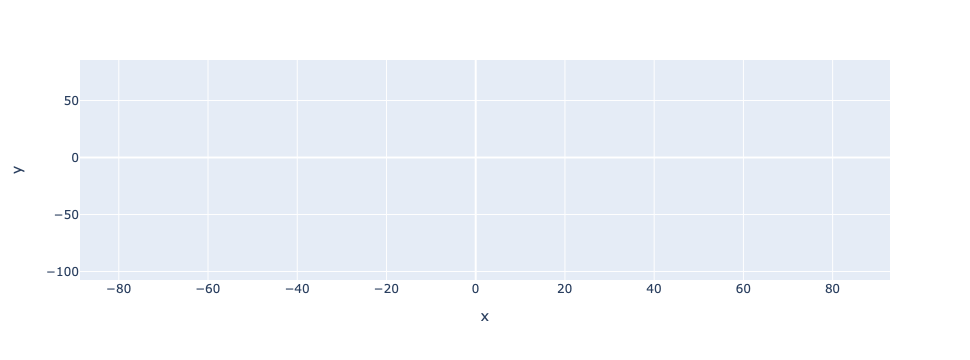

In [15]:
fig = px.scatter(
    X_2_tsne_labeled, 
    x="x", y="y", 
    text='education_field_of_study'
)

fig.update_traces(mode="markers")

fig.show()

In [17]:
fig.write_html("../figures/prep-embeddings/TSNE_{0}.html".format(datetime.datetime.now()))

# Clusterization

## k Measn

In [18]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [19]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(vec_embedding)

In [20]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [21]:
centroids.shape

(6, 768)

#### Clusterization metric

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 

In [22]:
metrics.silhouette_score(vec_embedding, labels, metric='euclidean')

0.2679504948843117

#### Группы

In [23]:
X_kmeans_labeled = pd.concat(
    [
        df_embeddings[['education_field_of_study', 'education_school_name']], 
        pd.DataFrame(labels, columns=['label'])
    ], 
    axis=1
)

In [24]:
X_kmeans_labeled

education_field_of_study  \
0                                      Entrepreneurship   
1                                                   NaN   
2                                            Economics    
3                                   Partially Completed   
4                                      Symbolic Systems   
...                                                 ...   
9845                          Metallurgical Engineering   
9846                                         Management   
9847                                Information Systems   
9848  Finance, Strategic Management and Entrepreneur...   
9849  Double Major: Finance, Investment & Banking; R...   

                                  education_school_name  label  
0                     University of Southern California      3  
1                               Harvard Business School      0  
2                                     Wellesley College      3  
3     University of California, Berkeley, Haas Schoo...      2  
4                                   Stanford University      2  
...                                                 ...    ...  
9845                          Seoul National University      4  
9846                                  Xavier University      3  
9847                           Georgia State University      5  
9848  The University of Chicago Booth School of Busi...      1  
9849                    University of Wisconsin-Madison      1  

[9850 rows x 3 columns]

In [25]:
X_kmeans_labeled['label'].value_counts()

1    2254
2    2180
0    2028
3    1547
4     950
5     891
Name: label, dtype: int64

#### Vis + TSNE

In [26]:
X_2_tsne_labeled = df_to_2_tsne(df_embeddings)

X_2_tsne_labeled = pd.concat(
    [
        X_2_tsne_labeled, 
        pd.DataFrame(labels, columns=['label'])
    ], 
    axis=1
)
X_2_tsne_labeled['label'] = 'label ' + X_2_tsne_labeled['label'].astype(str)

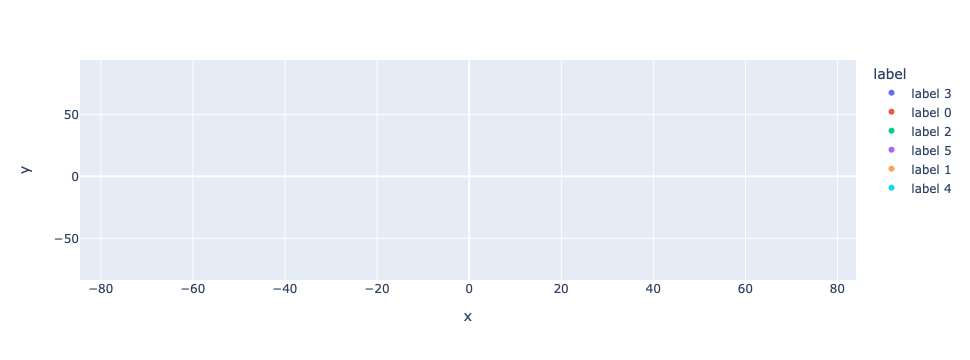

In [27]:
fig = px.scatter(
    X_2_tsne_labeled, 
    x="x", y="y", 
    text='education_field_of_study',
    color='label'
)

fig.update_traces(mode="markers")

fig.show()

In [28]:
fig.write_html("../figures/prep-embeddings/kMeans_{0}.html".format(datetime.datetime.now()))